In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from scipy import stats 
from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    return 

### CKS VII Sample (Fulton & Petigura 2018)
As a starting point we will begin with the CKS VII sample. This includes some planets which were not contained in Kepler Q1-Q17 DR25, so it allows us to study a larger sample.

In [2]:
data_dir = "../data/"

cks_st = Table.read(data_dir+"Fulton2018_stellarradii_ajaae828t2_mrt.txt", format='ascii')
cks_pl = Table.read(data_dir+"Fulton2018_planetradii_ajaae828t3_mrt.txt", format='ascii')

# In order to join the tables we need to reformat the KOI identifiers
cks_pl['KOI_star'] = np.array([(x.split(".")[0]) for x in cks_pl['KOI']])
cks_st.rename_column('KOI', 'KOI_star')

# Join the CKS tables
cks = join(cks_pl, cks_st, join_type='left', keys='KOI_star')

# Prepend a prefix to each column to help keep track of the provenance of the data
cks = cks.to_pandas()
prepend_dataframe_columns(cks, 'f18_')
cks.head(5)

# Planet detection statistics
cks_stats = Table.read('http://cdsarc.unistra.fr/ftp/J/AJ/156/264/table4.dat',
                 readme='http://cdsarc.unistra.fr/ftp/J/AJ/156/264/ReadMe',
                 format='ascii.cds')

cks_stats.info()
cks_stats = cks_stats.to_pandas()

cks = cks.merge(cks_stats, how='left', left_on='f18_KOI', right_on='KOI')

<Table length=907>
 name   dtype                      description                    
------ ------- ---------------------------------------------------
   KOI    str9     Kepler Object of Interest identfier (K0NNNN.NN)
   S/N float64 [4.19/4012.61] Signal-to-noise ratio in i bandimage
  Pdet float64                         [0/1] Detection probability
   Ptr float64                 [0.0016/0.3251] Transit probability
Weight float64                [3.28/7117158.76] Weight, 1/w_i_ (1)


### CKS I (Petigura et al. 2017)
For consistency with CKS VII, we will use the false positive designations adopted in Table 4 of CKS I, which themselves are based on a compilation of planet candidate dispositions from Morton et al. (2016), Mullaly et al. (2015), and the NASA Exoplanet Archive (as it was on Feb. 1, 2017).

In [3]:
p17 = Table.read('http://cdsarc.unistra.fr/ftp/J/AJ/154/107/table4.dat',
                 readme='http://cdsarc.unistra.fr/ftp/J/AJ/154/107/ReadMe',
                 format='ascii.cds')

p17 = p17.to_pandas()
#Munging
p17['Name'] = [x.replace('OI-', '') for x in p17['Name']]
p17 = p17.rename(columns={'Name':'KOI'})
prepend_dataframe_columns(p17, 'p17_')

p17.head()

,p17_KOI,p17_Disp,p17_M16,p17_M15,p17_NEA
0,K00001.01,CP,CP,CP,CP
1,K00002.01,CP,CP,CP,CP
2,K00003.01,CP,CP,CP,CP
3,K00006.01,FP,FP,FP,FP
4,K00007.01,CP,CP,CP,CP


### Kepler Q1-Q17 DR25 table
As a starting point we begin with the [Kepler Q1-Q17 DR 25 KOI Table](https://exoplanetarchive.ipac.caltech.edu/docs/PurposeOfKOITable.html#q1-q17_dr25) which is described in [Thompson et al. 2018](https://arxiv.org/abs/1710.06758)

In [4]:
dr25 = get_catalog('q1_q17_dr25_koi')
prepend_dataframe_columns(dr25, 'dr25_')
dr25.head()

,dr25_kepid,dr25_kepoi_name,dr25_kepler_name,dr25_ra,dr25_ra_err,dr25_ra_str,dr25_dec,dr25_dec_err,dr25_dec_str,dr25_koi_gmag,...,dr25_koi_fpflag_co,dr25_koi_fpflag_ec,dr25_koi_insol,dr25_koi_insol_err1,dr25_koi_insol_err2,dr25_koi_srho,dr25_koi_srho_err1,dr25_koi_srho_err2,dr25_koi_fittype,dr25_koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


### Kepler Stellar Data
We will also want the [Kepler Stellar data table](https://exoplanetarchive.ipac.caltech.edu/docs/Kepler_completeness_reliability.html) for the noise properties of each planet host. Since this is a large table, we have extracted the only columns we want ahead of time and stored this in the data directory.

In [5]:
stlr = pd.read_csv(data_dir+'Kepler-Q1-Q17-DR25-CDPP3.csv')
prepend_dataframe_columns(stlr, 'stlr_')
stlr.head()

,stlr_kepid,stlr_rrmscdpp03p0
0,10000785,445.410
1,10000797,80.767
2,10000800,226.348
3,10000823,181.468
4,10000827,124.834


### Gaia Kepler Stellar Properties Catalog (Berger et al. 2020)

In [6]:
b20 = pd.read_feather(data_dir+'GKSPCPapTable2.feather')
b20.head()

,b20_KIC,b20_iso_mass,b20_iso_mass_err1,b20_iso_mass_err2,b20_iso_teff,b20_iso_teff_err1,b20_iso_teff_err2,b20_iso_logg,b20_iso_logg_err1,b20_iso_logg_err2,...,b20_iso_age_err2,b20_iso_dis,b20_iso_dis_err1,b20_iso_dis_err2,b20_iso_avs,b20_iso_gof,b20_TAMS,b20_log10_iso_age,b20_E_log10_iso_age,b20_e_log10_iso_age
0,757076,1.396,0.179,-0.218,5052.2,103.9,-86.6,3.373,0.067,-0.081,...,-0.73,651.5,22.6,-21.6,0.371,1.0,2.69,9.392697,0.239760,0.152148
1,757099,0.873,0.054,-0.039,5364.9,102.7,-84.9,4.318,0.037,-0.029,...,-3.98,367.8,7.1,-6.9,0.340,1.0,17.18,10.181844,0.078228,0.131851
2,757137,1.669,0.309,-0.300,4628.7,84.8,-76.2,2.388,0.083,-0.086,...,-0.58,568.4,12.2,-11.6,0.344,1.0,1.66,9.178977,0.230956,0.210494
3,757280,1.715,0.086,-0.089,6856.8,144.4,-139.9,3.834,0.033,-0.032,...,-0.16,822.0,19.4,-21.0,0.496,1.0,1.62,9.093422,0.064941,0.059998
4,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,-5.15,829.6,24.0,-23.4,0.465,1.0,16.10,9.975891,0.194957,0.341414


### Petigura 2020
The radius valley is partially contaminated by planets with poorly determined radius ratios due to high impact parameters (grazing or near-grazing transits). Petigura 2020 devised a method to eliminate these planets with high confidence without performing new light curve fits.

In [7]:
url = "https://raw.githubusercontent.com/petigura/keprat/master/data/cksgaia-planets.csv"
s = requests.get(url).content
p20 = pd.read_csv(StringIO(s.decode('utf-8')))
p20['Rtau'] = p20.tau/p20.tau0
prepend_dataframe_columns(p20, 'p20_')

p20.head()

,p20_id_kic,p20_id_starname,p20_id_kic.1,p20_id_koi,p20_id_koicand,p20_id_kepler_name,p20_koi_disposition,p20_koi_period,p20_koi_period_err1,p20_koi_period_err2,...,p20_fgraz,p20_tau0,p20_tau,p20_dr25_ror_v18_srad,p20_dr25_ror_v18_srad_err1,p20_dr25_ror_gdir_srad,p20_dr25_ror_gdir_srad_err1,p20_v18_ror_gdir_srad,p20_v18_ror_gdir_srad_err1,p20_Rtau
0,757450,K00889,757450,889.0,K00889.01,Kepler-75 b,CONFIRMED,8.884923,0.000001,-0.000001,...,0.0,4.019727,1.856715,NaN,NaN,11.802615,0.412225,NaN,NaN,0.461901
1,1026957,K00958,1026957,958.0,K00958.01,NaN,NOT DISPOSITIONED,21.761294,0.000011,-0.000011,...,0.0,4.427408,1.204967,NaN,NaN,2.478217,0.114768,NaN,NaN,0.272161
2,1718189,K00993,1718189,993.0,K00993.01,Kepler-262 c,CONFIRMED,21.853679,0.000097,-0.000097,...,0.0,4.914936,3.306574,NaN,NaN,1.551245,0.081248,NaN,NaN,0.672760
3,1718189,K00993,1718189,993.0,K00993.02,Kepler-262 b,CONFIRMED,13.060767,0.000092,-0.000092,...,0.0,4.139989,3.093553,NaN,NaN,1.267332,0.068661,NaN,NaN,0.747237
4,1718189,K00993,1718189,993.0,K00993.03,NaN,CANDIDATE,86.723152,0.001814,-0.001814,...,0.0,7.781345,4.761139,NaN,NaN,1.257706,0.094337,NaN,NaN,0.611866


### Results from fitting skew normal distributions to age PPFs from CKS

In [8]:
skew = pd.read_csv(data_dir+'cks-skewnormal-shape-parameters.csv')
skew.head()

,KOI,logAiso,E_logAiso,e_logAiso,a3,loc3,scale3,a5,loc5,scale5
0,K00001,9.74,0.13,0.15,-1.723381,9.866322,0.196824,-0.844107,9.817946,0.165594
1,K00002,9.25,0.04,0.05,-2.321427,9.294849,0.067507,-1.059536,9.278683,0.055756
2,K00006,9.32,0.09,0.24,-23.351389,9.482107,0.278910,-3.731076,9.472594,0.270625
3,K00007,9.78,0.09,0.08,1.544269,9.706938,0.116269,0.030719,9.789814,0.087285
4,K00008,9.18,0.26,0.52,-24.799017,9.590470,0.653710,-2.445676,9.518279,0.588301


### Merging tables

In [9]:
# First drop nine stars without CKS ages. 
# These present problems later in the MC simulation when attempting to sample from a skew normal distribution. 
# Excluding them changes nothing about the results.
cks = cks.dropna(subset=['f18_logAiso'])

In [10]:
print(len(cks))
cks = cks.merge(p17, how='left', left_on='f18_KOI', right_on='p17_KOI')
print(len(cks))
cks = cks.merge(dr25, how='left', left_on='f18_KOI', right_on='dr25_kepoi_name')
print(len(cks))
cks = cks.merge(stlr, how='left', left_on='dr25_kepid', right_on='stlr_kepid')
print(len(cks))
cks = cks.merge(p20, how='left', left_on='dr25_kepoi_name', right_on='p20_id_koicand')
print(len(cks))
cks = cks.merge(b20, how='left', left_on='dr25_kepid', right_on='b20_KIC')
print(len(cks))
cks = cks.merge(skew, how='left', left_on='f18_KOI_star', right_on='KOI')
print(len(cks))

1892
1892
1892
1892
1892
1892
1892


### Defining new columns that will be used in the masks

In [11]:
cks['f18_depth_ppm'] = (cks['f18_Rp/R*']**2.0)/1e-6
cks['single_transit_snr'] = 1.0e6*((1.0*c.R_earth.value)/(cks['f18_R']*c.R_sun.value))**2. * 1.0/cks['stlr_rrmscdpp03p0']
cks['Rcut'] = 10.**((cks['f18_Teff']-5500)/4500 + 0.25) #Fulton & Petigura use 0.2 instead of 0.25
cks['nplanets'] =[np.sum(x == cks['f18_KOI_star']) for x in cks['f18_KOI_star']]

In [12]:
#Let's declare a new variable to store the original CKS dataframe, 
#as we will soon appply masks to restrict our analysis to a subset of the sample with high reliability.
cks_base = pd.DataFrame(cks)

In [13]:
#Plotting defaults
sns.set(font_scale=1, context="paper", style="ticks")
ebar_kwargs = {'alpha': 0.5, 'fmt':'o', 'ecolor': 'lightgrey', 'ms': 1, 'lw':0.5}
line_kwargs = {'ls':'--', 'color':'k', 'lw': 0.5}

yng_color = '#4d73c4'
old_color = '#f25b24'

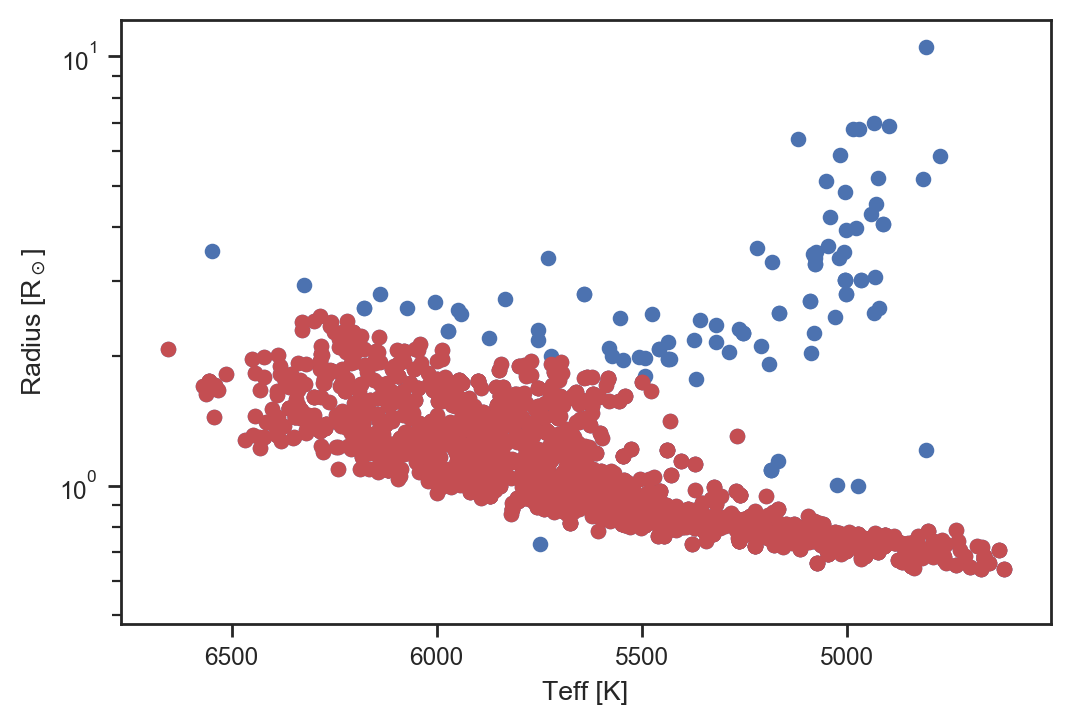

In [14]:
from scipy import interpolate 

#Non-rotating Fe/H = +0.25 MIST isochrones
mistp = pd.read_feather(data_dir+'MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_abridged.feather')

# Improved MS cut
def maxage_teff(rstar):
    arg = (mistp['log10_isochrone_age_yr']==10.25)&(mistp['EEP']<500)
    f = interpolate.interp1d(10.**mistp['log_R'][arg], 
                             10.**mistp['log_Teff'][arg], 
                             kind='cubic', fill_value='extrapolate')
    return f(rstar)

#We wish to remove stars that obviously fall below the main sequence as these may have unreliable stellar parameters
m_onms = cks['f18_R'] > 10.**((cks['f18_Teff']-5500)/7000 - 0.15)
#Our study will focus stars which have not evolved far off the main sequence
m_unevolved = cks['f18_R'] < 10.**((cks['f18_Teff']-5500)/4500 + 0.25)
#Some cool stars appear to be elevated from the main-sequence, corresponding to ages older than the universe
#even if they are metal-rich.
m_unelevated = cks['f18_Teff'] > maxage_teff(cks['f18_R'])

#Plot the cut in the HR diagram
m_ms = m_onms & m_unevolved & m_unelevated

plt.scatter(cks['f18_Teff'], cks['f18_R'])
plt.scatter(cks['f18_Teff'][m_ms], cks['f18_R'][m_ms], color='r')
plt.gca().invert_xaxis()
plt.semilogy()
plt.xlabel('Teff [K]')
plt.ylabel('Radius [R$_\odot$]')
plt.show()

### Masks

In [15]:
mstar_min, mstar_max = 0.75, 1.25
period_max = 100.
r8_max = 1.1
rcf_max = 1.05
abs_feh_max = 0.15
ruwe_max = 1.4
rp_max = 5.
snr_min = 0.45

sigmarp_max = 0.1

print(len(cks), 'planets')

# Remove False Positives
m_fp = cks['p17_Disp'] != 'FP'
print(len(cks[~m_fp]), 'planets with FP disposition')

# Remove stars with flux contamination determined from Gaia
m_r8 = cks['f18_r8'] < r8_max
print(len(cks[~m_r8]), 'planets fail r8 cut')

# Exclude stars with flux contamination from follow-up high-res imaging
m_RCF = np.invert(cks['f18_RCF'] >= rcf_max)
print(len(cks[~m_RCF]), 'planets fail RCF cut')

# Exclude long period planets
m_P = cks['f18_P'] < period_max
print(len(cks[~m_P]), 'planets fail period cut')

# Signal-to-noise cut
m_snr = cks['single_transit_snr'] > snr_min
print(len(cks[~m_snr]), 'planets fail SNR cut')

# Well-determined planet radii
m_radiusprec = np.all(np.array([cks['f18_e_Rp']/cks['f18_Rp'], cks['f18_E_Rp']/cks['f18_Rp']])<sigmarp_max, axis=0)
print(len(cks[~m_radiusprec]), 'planets fail radius precision cut')

# Small planets
m_rp = cks['f18_Rp']<rp_max
print(len(cks[~m_rp]), 'planets fail radius cut')

# Stars with discrepant Gaia and isochrone parallaxes
m_parallaxagree = abs(cks['f18_plx']-cks['f18_plxspec'])/np.min(np.array([cks['f18_e_plxspec'],cks['f18_E_plxspec']]), axis=0) < 4
print(len(cks[~m_parallaxagree]), 'planets fail parallax agreement test')

# Planets with grazing transits
m_grazing = cks['p20_Rtau'] >= 0.6
print(len(cks[~m_grazing]), 'planets with grazing transits')

m_logaisonan = ~cks['f18_logAiso'].isna()
print(len(cks[~m_logaisonan]), 'planets have undefined logAiso')

m_misonan = (cks['f18_Miso']>0)
print(len(cks[~m_misonan]), 'planets have zero mass')

# Finite shape parameters from skew normal fits
m_shape = np.isfinite(cks['loc3'])
print(len(cks[~m_shape]), 'planets do not have finite shape parameters')

#Submitted version:
base_sample = m_fp & m_P & m_snr & m_misonan & m_logaisonan & m_parallaxagree & m_shape #& m_radiusprec

restricted_sample = m_fp & m_P & m_rp & m_snr &\
                    (cks['f18_Miso']<1) &\
                    (abs(cks['f18_[Fe/H]']-np.median(cks['f18_[Fe/H]']))<0.075) &\
                    (cks['f18_R']<1.05)


print(len(cks[base_sample]), 'planets remaining after cuts in base sample')
print(len(np.unique(cks['f18_KOI_star'][base_sample])), 'unique hosts remaining after cuts in base sample')

print(len(cks[restricted_sample]), 'planets remaining after cuts in restricted sample')
print(len(np.unique(cks['f18_KOI_star'][restricted_sample])), 'unique hosts remaining after cuts in restricted sample')

1892 planets
148 planets with FP disposition
134 planets fail r8 cut
70 planets fail RCF cut
222 planets fail period cut
524 planets fail SNR cut
314 planets fail radius precision cut
233 planets fail radius cut
91 planets fail parallax agreement test
589 planets with grazing transits
0 planets have undefined logAiso
0 planets have zero mass
0 planets do not have finite shape parameters
1158 planets remaining after cuts in base sample
718 unique hosts remaining after cuts in base sample
202 planets remaining after cuts in restricted sample
117 unique hosts remaining after cuts in restricted sample


/Users/tdavid/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


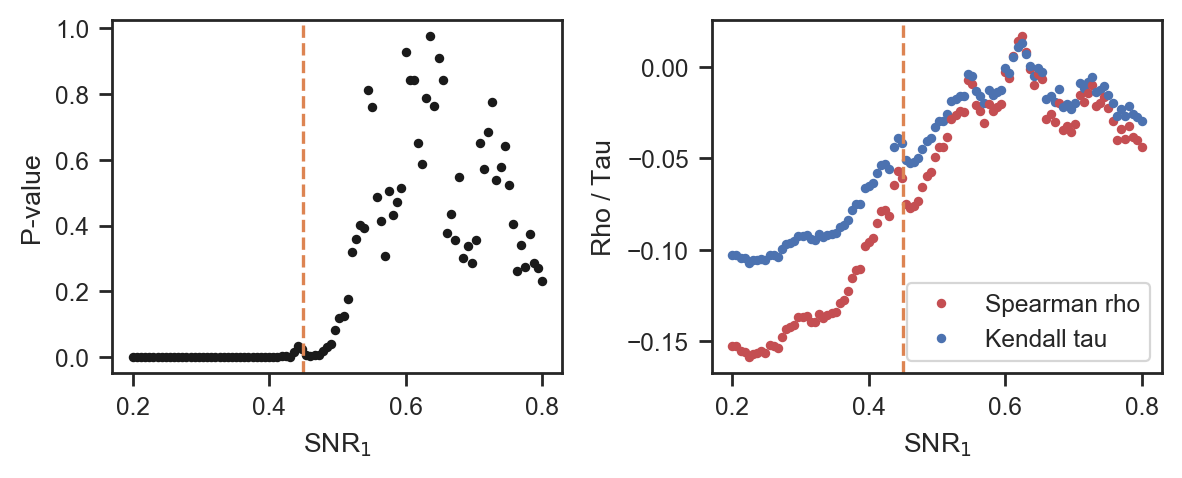

In [16]:
age = cks['f18_logAiso']

snrgrid = np.linspace(0.2,0.8,100)
fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))
for i,_snr in enumerate(snrgrid):
    newm = (cks['single_transit_snr']>_snr) & (np.isfinite(cks['f18_logAiso']))
    rho, pval = stats.spearmanr(age[newm], cks['single_transit_snr'][newm])
    ax1.plot(_snr, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['single_transit_snr'][newm])
    if i==0:
        ax2.plot(_snr, rho, 'r.', label='Spearman rho')
        ax2.plot(_snr, tau, 'b.', label='Kendall tau')
    else:
        ax2.plot(_snr, rho, 'r.')
        ax2.plot(_snr, tau, 'b.')

    
ax1.axvline(snr_min, ls='--', color='C1')
ax2.axvline(snr_min, ls='--', color='C1')
ax1.set_xlabel('SNR$_1$')
ax2.set_xlabel('SNR$_1$')
ax1.set_ylabel('P-value')
ax2.set_ylabel('Rho / Tau')
plt.tight_layout()
plt.legend()
plt.show()

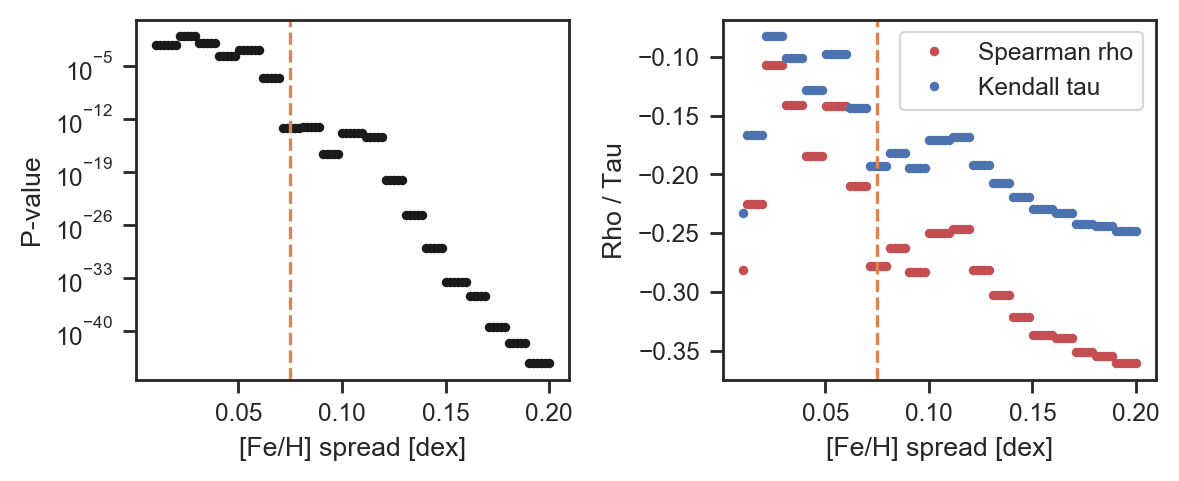

In [17]:
fehgrid = np.linspace(0.01,0.2,100)

_base = (np.isfinite(cks['f18_logAiso'])) & (np.isfinite(cks['f18_[Fe/H]'])) & (cks['f18_Miso']>0.0)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))
for i,_fehwid in enumerate(fehgrid):
    newm = _base & (abs(cks['f18_[Fe/H]']-np.median(cks['f18_[Fe/H]']))<_fehwid)
    rho, pval = stats.spearmanr(age[newm], cks['f18_[Fe/H]'][newm])
    ax1.plot(_fehwid, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['f18_[Fe/H]'][newm])
    
    if i==0:
        ax2.plot(_fehwid, rho, 'r.', label='Spearman rho')
        ax2.plot(_fehwid, tau, 'b.', label='Kendall tau')
    else:
        ax2.plot(_fehwid, rho, 'r.')
        ax2.plot(_fehwid, tau, 'b.')        
    
    #if pval>0.0001:
    #    print(_fehwid, pval)    
    
ax1.axvline(0.075, ls='--', color='C1')
ax2.axvline(0.075, ls='--', color='C1')
ax1.set_xlabel('[Fe/H] spread [dex]')
ax2.set_xlabel('[Fe/H] spread [dex]')
ax1.set_ylabel('P-value')
ax2.set_ylabel('Rho / Tau')
ax1.semilogy()
plt.tight_layout()
plt.legend()
plt.show()

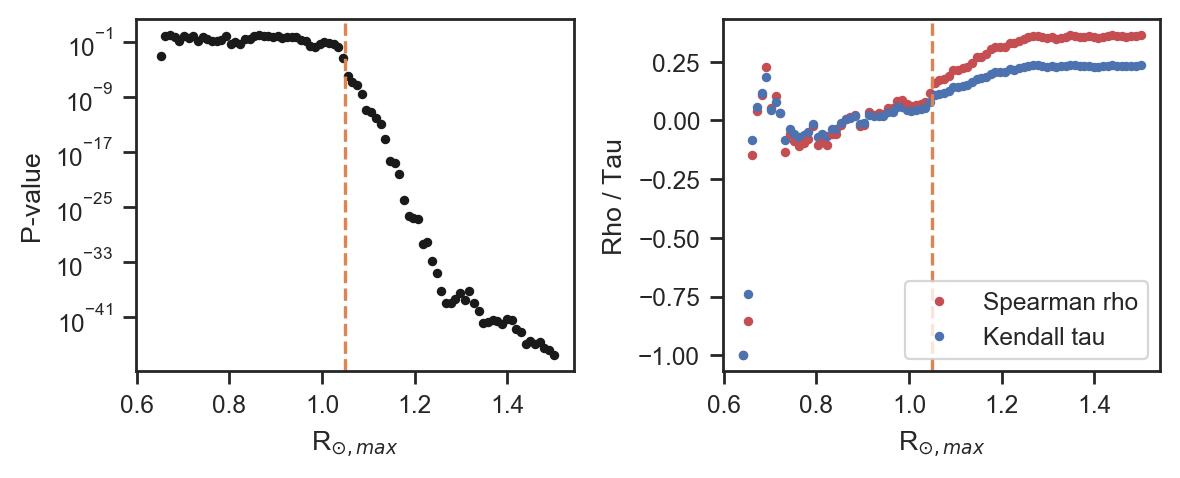

In [18]:
rstargrid = np.linspace(0.5,1.5,100)

_base = (np.isfinite(cks['f18_logAiso'])) & (np.isfinite(cks['f18_[Fe/H]'])) & (cks['f18_Miso']>0.0)

fig,(ax1,ax2) = plt.subplots(ncols=2, figsize=(6,2.5))

for i,rmax in enumerate(rstargrid):
    newm = _base & (cks['f18_R']<rmax)
    rho, pval = stats.spearmanr(age[newm], cks['f18_R'][newm])    
    ax1.plot(rmax, pval, 'k.')
    tau, _pval = stats.kendalltau(age[newm], cks['f18_R'][newm])    
    if i==0:
        ax2.plot(rmax, rho, 'r.', label='Spearman rho')
        ax2.plot(rmax, tau, 'b.', label='Kendall tau')
    else:
        ax2.plot(rmax, rho, 'r.')
        ax2.plot(rmax, tau, 'b.')
      
    #if pval>0.01:
    #    print(rmax, pval)        
    
ax1.axvline(1.05, ls='--', color='C1')
ax2.axvline(1.05, ls='--', color='C1')
ax1.set_xlabel('R$_{\odot,max}$')
ax2.set_xlabel('R$_{\odot,max}$')
ax1.set_ylabel('P-value')
ax2.set_ylabel('Rho / Tau')
ax1.semilogy()
plt.tight_layout()
plt.legend()
plt.show()

### Visualizing parameter correlations in the sample (Fig. 1)

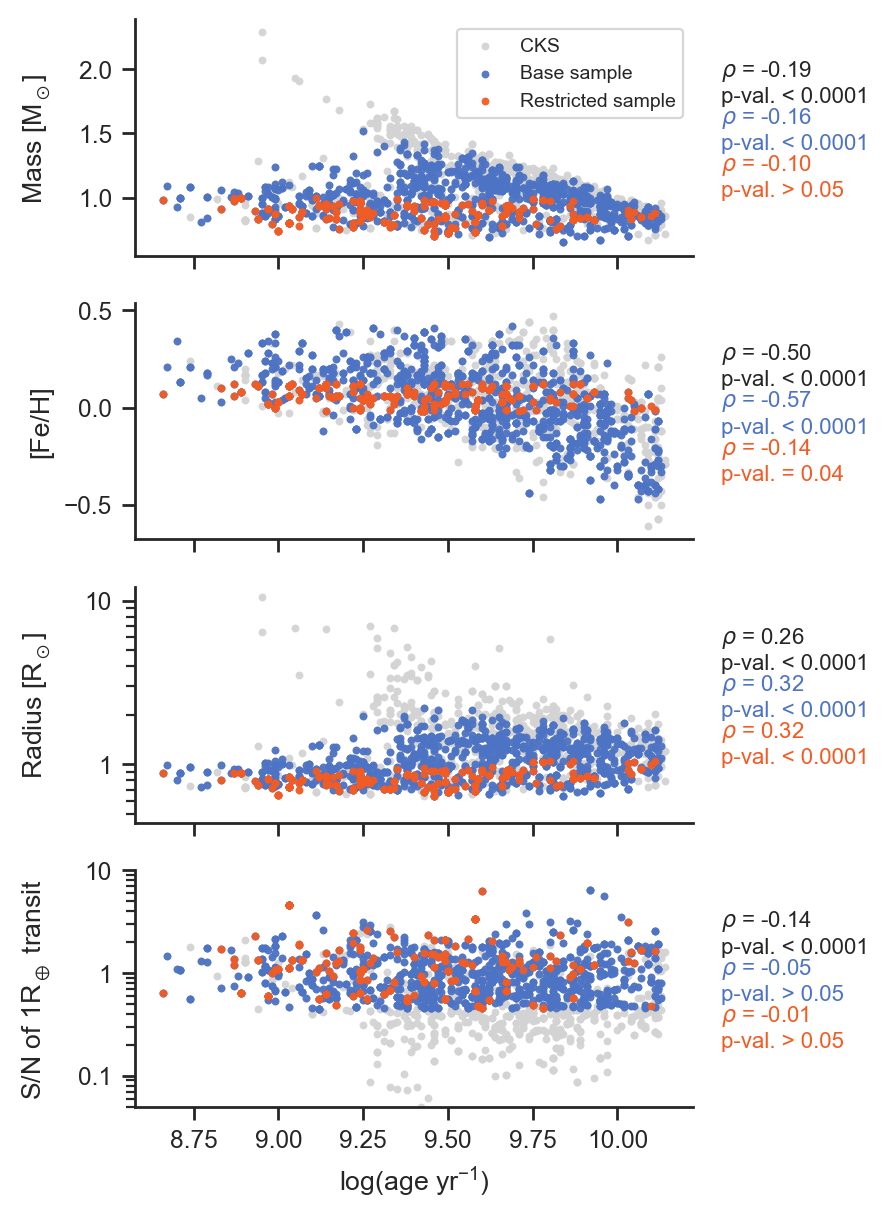

In [19]:
def sample_correlation_plot(fig_path=None):
    
    scatter_kwargs = {'alpha': 0.95, 's': 8, 'lw':0, 'rasterized': True}
    text_kwargs = {'size':8}

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(0.9*4,0.9*8), sharex=True)


    age = cks['f18_logAiso']

    variables = [cks['f18_Miso'], 
                 cks['f18_[Fe/H]'],
                 cks['f18_R'],
                 cks['single_transit_snr']]

    def f2str(n, limit=False, sci_not=False):
        if sci_not==True:
            return "{:.2e}".format(n)
        if (limit==True) and (n<0.0001):
            return " < 0.0001"
        if (limit==True) and (n>0.05):
            return " > 0.05"        
        else:
            return " = "+"{:.2f}".format(n)


    for i,var in enumerate(variables):

        mask1 = (np.isfinite(age)) & (np.isfinite(var))
        mask2 = mask1 & base_sample
        mask3 = mask1 & restricted_sample

        rho1, pval1 = stats.spearmanr(age[mask1], var[mask1])
        rho2, pval2 = stats.spearmanr(age[mask2], var[mask2])
        rho3, pval3 = stats.spearmanr(age[mask3], var[mask3])


        ax[i].scatter(age, var, color='lightgrey', **scatter_kwargs, label='CKS')    
        ax[i].scatter(age[mask2], var[mask2], color=yng_color, **scatter_kwargs, label='Base sample')
        ax[i].scatter(age[mask3], var[mask3], color=old_color, **scatter_kwargs, label='Restricted sample')
        ax[i].text(1.05,0.65,r'$\rho$'+f2str(rho1)+'\np-val.'+f2str(pval1, sci_not=False, limit=True), transform=ax[i].transAxes, **text_kwargs)    
        ax[i].text(1.05,0.45,r'$\rho$'+f2str(rho2)+'\np-val.'+f2str(pval2, sci_not=False, limit=True), transform=ax[i].transAxes, color=yng_color, **text_kwargs)
        ax[i].text(1.05,0.25,r'$\rho$'+f2str(rho3)+'\np-val.'+f2str(pval3, sci_not=False, limit=True), transform=ax[i].transAxes, color=old_color, **text_kwargs)

        if i==0:
            ax[i].legend(loc='upper right', prop={'size':7})

        if i>=2:
            ax[i].semilogy()

    ax[2].set_yticks([1,10])        
    ax[2].set_yticklabels(['1','10'])        

    ax[3].set_xlabel(r'log(age yr$^\mathregular{-1}$)') 
    ax[3].set_yticks([0.1,1,10])
    ax[3].set_yticklabels(['0.1','1','10'])
    ax[3].set_ylim(0.05,10)

    ax[0].set_ylabel(r'Mass [$\mathregular{M_\odot}$]')
    ax[1].set_ylabel('[Fe/H]')
    ax[2].set_ylabel(r'Radius [$\mathregular{R_\odot}$]')
    ax[3].set_ylabel(r'S/N of 1$\mathregular{R_\oplus}$ transit')        

    sns.despine()

    fig.align_ylabels(ax)
    if fig_path:
        plt.savefig(fig_path, dpi=300)
    plt.show()
    
    return

sample_correlation_plot('../figures/sample.pdf')

### Visualizing differential completeness as a function of age (Fig. 2)

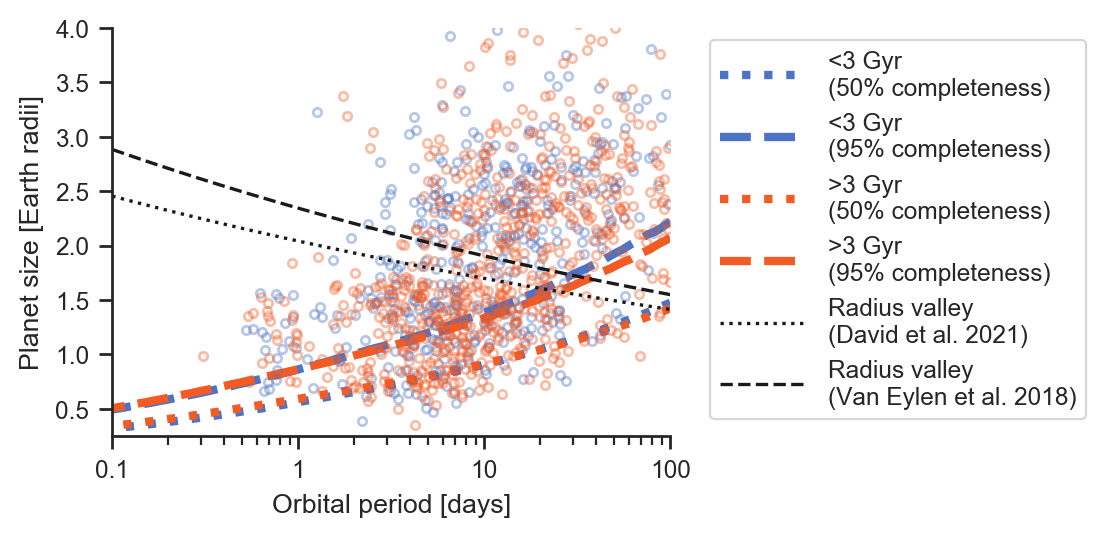

In [20]:
#Completeness maps
base_lt_1gyr = base_sample & (cks['f18_logAiso']<=9.)
base_gt_1gyr = base_sample & (cks['f18_logAiso']>9.)

base_1gyr3gyr = base_sample & (cks['f18_logAiso']>9.) & (cks['f18_logAiso']<=np.log10(3.0e9))

base_lt_3gyr = base_sample & (cks['f18_logAiso']<=np.log10(3.0e9))
base_gt_3gyr = base_sample & (cks['f18_logAiso']>np.log10(3.0e9))

# new_df = pd.DataFrame({'cks_kepid': cks['dr25_kepid'][base_sample], 
#                        'cks_mass': cks['f18_Miso'][base_sample],
#                        'cks_radius': cks['f18_R'][base_sample],
#                        'agegyr': 10.**cks['f18_logAiso'][base_sample]/1.0e9})
# new_df = new_df.drop_duplicates(subset=['cks_kepid'])

# new_df.to_csv('base_sample.csv', index=False)

def Rp_valley(P, ref='D20'):
    if ref=='V18':
        a, b = -0.09, 0.37
    elif ref=='D20':
        a, b = -0.08, 0.31
    elif ref=='RO20':
        a, b = 0.0, np.log10(1.8)
    return 10**(a*np.log10(P) + b)


def completeness_plot(fig_path=None):


    files = ['cks_base_lt_3gyr_50pct.csv', 'cks_base_lt_3gyr_95pct.csv',
            'cks_base_gt_3gyr_50pct.csv', 'cks_base_gt_3gyr_95pct.csv']

    ls = [':', '--', ':', '--']
    labels = ['<3 Gyr\n(50% completeness)', '<3 Gyr\n(95% completeness)', 
              '>3 Gyr\n(50% completeness)', '>3 Gyr\n(95% completeness)']
    colors = [yng_color, yng_color, old_color, old_color]

    for i,f in enumerate(files):
        df = pd.read_csv(data_dir+'completeness/'+f)
        plt.plot(df['p'], df['rp'], ls=ls[i], color=colors[i], label=labels[i], lw=3)

    plt.semilogx()
    p_grid = np.logspace(-1,2,100)

    plt.plot(cks['f18_P'][base_lt_3gyr],
             cks['f18_Rp'][base_lt_3gyr], 'o', mfc='None', color=yng_color, ms=3, alpha=0.4, rasterized=True)
    plt.plot(cks['f18_P'][base_gt_3gyr],
             cks['f18_Rp'][base_gt_3gyr], 'o', mfc='None', color=old_color, ms=3, alpha=0.4, rasterized=True)

    plt.plot(p_grid,Rp_valley(p_grid, ref='D20'), 'k:', label='Radius valley\n(David et al. 2021)')
    plt.plot(p_grid,Rp_valley(p_grid, ref='V18'), 'k--', label='Radius valley\n(Van Eylen et al. 2018)')
    plt.ylim(0.25,4)
    plt.xlim(0.1,100)
    plt.xticks([0.1,1,10,100],['0.1','1','10','100'])
    plt.xlabel('Orbital period [days]')
    plt.ylabel('Planet size [Earth radii]')
    plt.legend(handlelength=3.6, bbox_to_anchor=(1.05,1))
    plt.gcf().set_size_inches(0.9*4,0.9*3)
    sns.despine()
    if fig_path:
        plt.savefig(fig_path, dpi=300)
    plt.show()
    
    return

completeness_plot('../figures/completeness.pdf')

In [21]:
def mc_simulation(cks, m, 
                 _binwidth=0.125, 
                 nsamples=10000, 
                 age_ref='cks', 
                 age_dist='normal', 
                 rv_ref='D20'):
    
    np.random.seed(2020)
    
    bin_centers = np.linspace(8.5,10,50)
    ratio = np.zeros([len(bin_centers), nsamples])
    
    if age_ref == 'cks':
        age_med, age_err_lo, age_err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
        age_a3, age_loc3, age_scale3 = cks['a3'], cks['loc3'], cks['scale3']
        age_a5, age_loc5, age_scale5 = cks['a5'], cks['loc5'], cks['scale5']
                
    elif age_ref == 'berger':
        age_med, age_err_lo, age_err_hi = cks['b20_log10_iso_age'], cks['b20_e_log10_iso_age'], cks['b20_E_log10_iso_age']     
        
    if age_dist == 'normal':
        mc_age = np.array([np.random.normal(age_med, np.max([age_err_lo, age_err_hi], 
                                                            axis=0)) for n in range(nsamples)])
    elif age_dist == 'uniform':
        mc_age = np.array([np.random.uniform(age_med-age_err_lo, age_med+age_err_hi) for n in range(nsamples)])
        
    elif age_dist == 'skewnormal':
        mc_age = np.array([stats.skewnorm.rvs(a=age_a3, loc=age_loc3, scale=age_scale3) for n in range(nsamples)])        

    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic, ref=rv_ref)
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_age>=bin_centers[i]-_binwidth) & (mc_age<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    
    return bin_centers, ratio

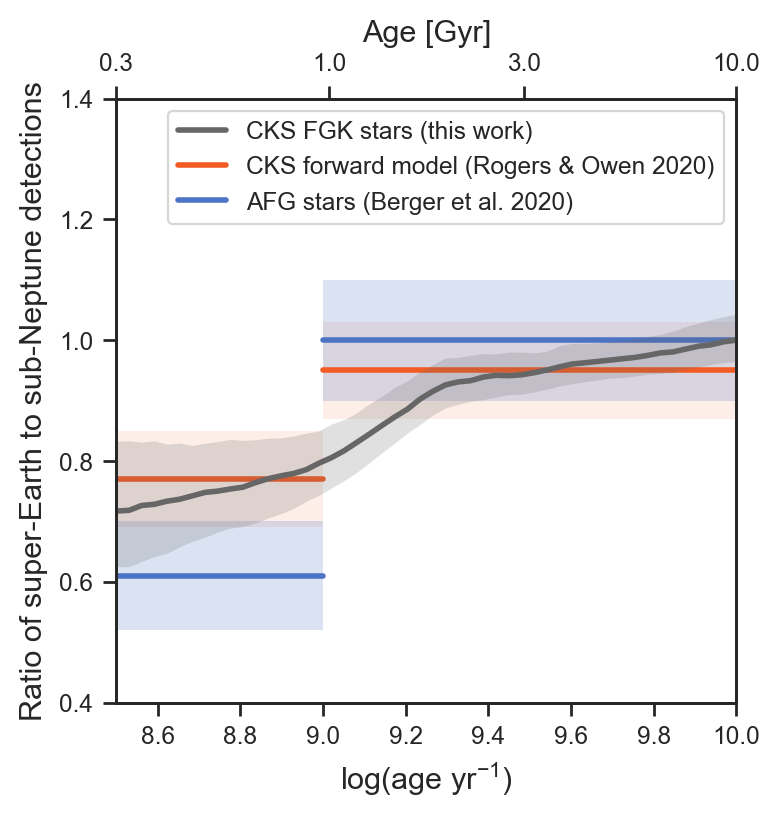

SE/SN ratio (<1 Gyr) =  0.756 +/- 0.082
SE/SN ratio (>1 Gyr) =  0.936 +/- 0.065
Significance (sigma): -1.717
SE/SN ratio (<3 Gyr) =  0.819 +/- 0.1
SE/SN ratio (>3 Gyr) =  0.973 +/- 0.038
Significance (sigma): -1.432


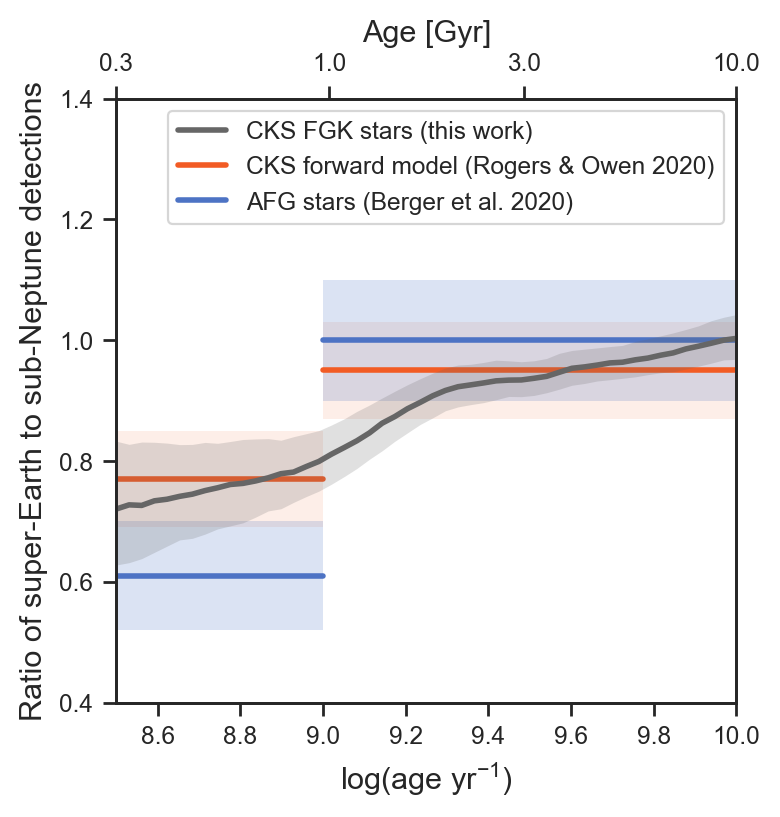

SE/SN ratio (<1 Gyr) =  0.76 +/- 0.079
SE/SN ratio (>1 Gyr) =  0.932 +/- 0.062
Significance (sigma): -1.712
SE/SN ratio (<3 Gyr) =  0.82 +/- 0.094
SE/SN ratio (>3 Gyr) =  0.969 +/- 0.038
Significance (sigma): -1.466


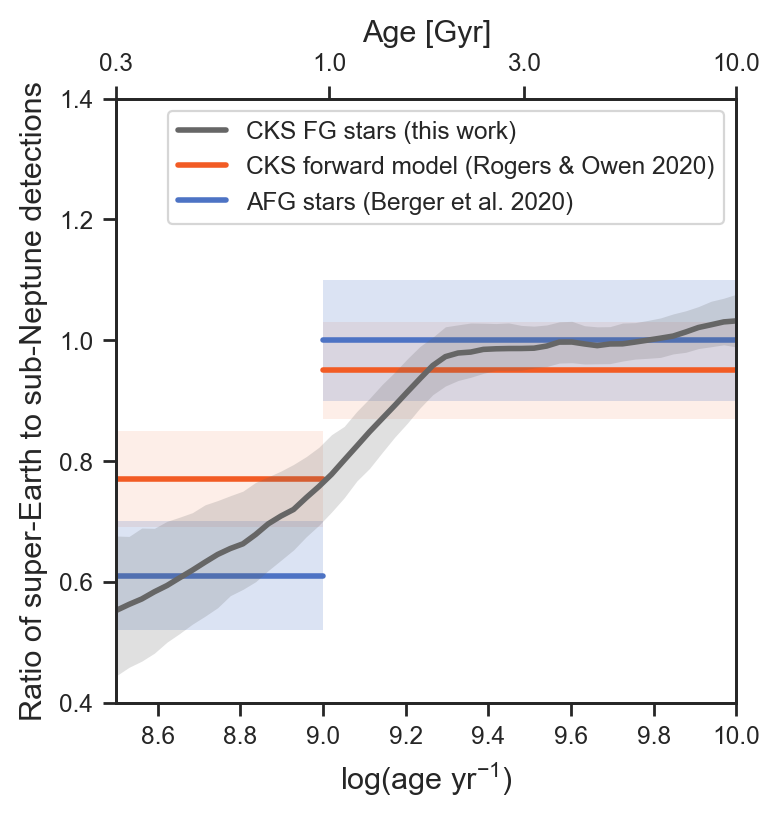

SE/SN ratio (<1 Gyr) =  0.651 +/- 0.111
SE/SN ratio (>1 Gyr) =  0.964 +/- 0.079
Significance (sigma): -2.3
SE/SN ratio (<3 Gyr) =  0.775 +/- 0.166
SE/SN ratio (>3 Gyr) =  1.004 +/- 0.037
Significance (sigma): -1.348


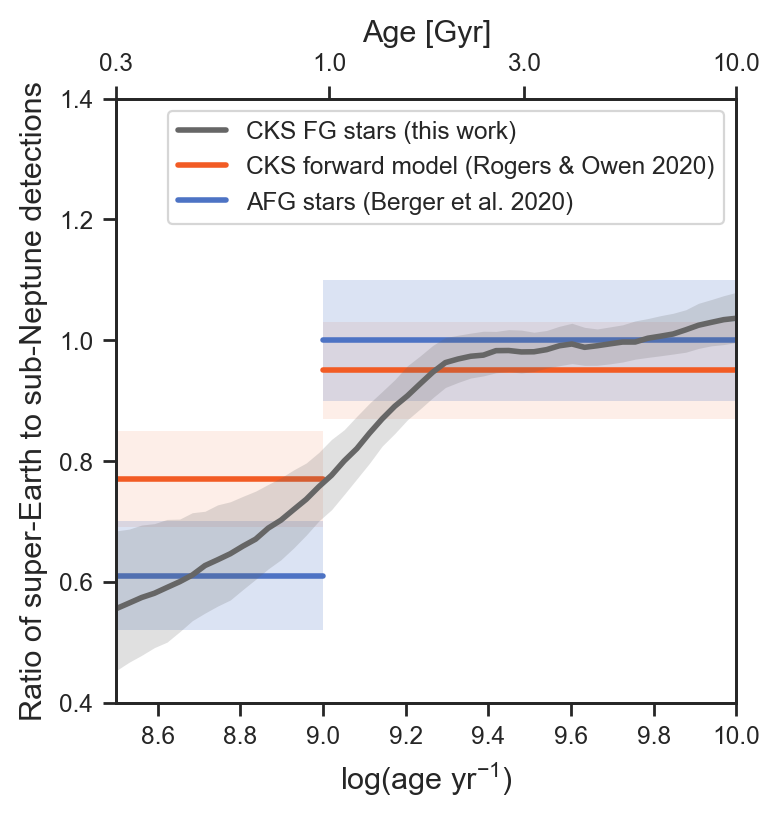

SE/SN ratio (<1 Gyr) =  0.649 +/- 0.105
SE/SN ratio (>1 Gyr) =  0.961 +/- 0.078
Significance (sigma): -2.391
SE/SN ratio (<3 Gyr) =  0.771 +/- 0.161
SE/SN ratio (>3 Gyr) =  1.003 +/- 0.038
Significance (sigma): -1.403


In [22]:
def report_results(sample_mask, sample_label,
                  age_dist='normal',
                  rv_ref='D20',
                  fig_path=None):
    
    bin_centers, _ratio = mc_simulation(cks, m=sample_mask, _binwidth=0.5, 
                                        age_ref='cks', 
                                        age_dist=age_dist, 
                                        rv_ref=rv_ref, nsamples=1000)


    clr = '#666666'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twiny()


    ax.plot(bin_centers, np.nanmedian(_ratio, axis=1), color=clr, label=sample_label, lw=2, zorder=999)


    for ci in [68.3]:
        ax.fill_between(bin_centers, 
                     np.nanpercentile(_ratio, 50.-0.5*ci, axis=1), 
                     np.nanpercentile(_ratio, 50.+0.5*ci, axis=1), 
                     alpha=0.2, color=clr, lw=0, zorder=999)

    ax.set_xlabel(r'log(age yr$^\mathregular{-1}$)', size=11)
    ax.set_ylabel('Ratio of super-Earth to sub-Neptune detections', size=11)


    #Rogers & Owen 2020
    ro_color = '#d4689f'

    ax.plot([8.25,9],[0.77,0.77], old_color, label='CKS forward model (Rogers & Owen 2020)', lw=2)
    ax.fill_between([8.25,9],0.77-0.08,0.77+0.08, alpha=0.1, color=old_color, lw=0)
    ax.plot([9,10.25],[0.95,0.95], old_color, lw=2)
    ax.fill_between([9,10.25],0.95-0.08,0.95+0.08, alpha=0.1, color=old_color, lw=0)

    #Berger et al. 2020
    be_color = '#597cde'

    ax.plot([8.25,9],[0.61,0.61], color=yng_color, label='AFG stars (Berger et al. 2020)', lw=2)
    ax.fill_between([8.25,9],0.61-0.09,0.61+0.09, alpha=0.2, color=yng_color, lw=0)
    ax.plot([9,10.25],[1,1], color=yng_color, lw=2)
    ax.fill_between([9,10.25],1-0.1,1+0.1, alpha=0.2, color=yng_color, lw=0)

    ax.set_xlim(bin_centers.min(), bin_centers.max())
    ax.set_ylim(0.4,1.4)
    ax.legend()

    new_tick_locations = np.log10([3e8,1e9,3e9,1e10])

    def tick_function(X):
        V = 10.**X/(1.0e9)
        return ["%.1f" % z for z in V]

    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"Age [Gyr]", size=11)

    plt.gcf().set_size_inches(4,4)
    if fig_path:
        plt.savefig(fig_path)
    plt.show()

    print('SE/SN ratio (<1 Gyr) = ', np.round(np.mean(_ratio[bin_centers<=9]),3),'+/-',np.round(np.std(_ratio[bin_centers<=9]),3))
    print('SE/SN ratio (>1 Gyr) = ', np.round(np.mean(_ratio[bin_centers>9]),3),'+/-',np.round(np.std(_ratio[bin_centers>9]),3))
    _err = np.sqrt(np.std(_ratio[bin_centers<=9])**2 + np.std(_ratio[bin_centers>9])**2)
    #_err = np.max([np.std(_ratio[bin_centers<=9]), np.std(_ratio[bin_centers>9])])
    print('Significance (sigma):', np.round((np.mean(_ratio[bin_centers<=9])-np.mean(_ratio[bin_centers>9]))/_err, 3))

    print('SE/SN ratio (<3 Gyr) = ', np.round(np.mean(_ratio[bin_centers<=np.log10(3e9)]),3),'+/-',np.round(np.std(_ratio[bin_centers<=np.log10(3e9)]),3))
    print('SE/SN ratio (>3 Gyr) = ', np.round(np.mean(_ratio[bin_centers>np.log10(3e9)]),3),'+/-',np.round(np.std(_ratio[bin_centers>np.log10(3e9)]),3))
    _err = np.sqrt(np.std(_ratio[bin_centers<=np.log10(3e9)])**2 + np.std(_ratio[bin_centers>np.log10(3e9)])**2)
    #_err = np.max([np.std(_ratio[bin_centers<=np.log10(3e9)]), np.std(_ratio[bin_centers>np.log10(3e9)])])
    print('Significance (sigma):', np.round((np.mean(_ratio[bin_centers<=np.log10(3e9)])-np.mean(_ratio[bin_centers>np.log10(3e9)]))/_err, 3))
    
    return
    
report_results(base_sample, sample_label='CKS FGK stars (this work)', age_dist='normal', fig_path='../figures/ratio.pdf')
report_results(base_sample, sample_label='CKS FGK stars (this work)', age_dist='skewnormal')

report_results(base_sample&(cks['f18_Teff']>5500), sample_label='CKS FG stars (this work)', age_dist='normal', fig_path='../figures/ratio-hot.pdf')
report_results(base_sample&(cks['f18_Teff']>5500), sample_label='CKS FG stars (this work)', age_dist='skewnormal')

### What about the effects of mass and metallicity? (Fig. 4)

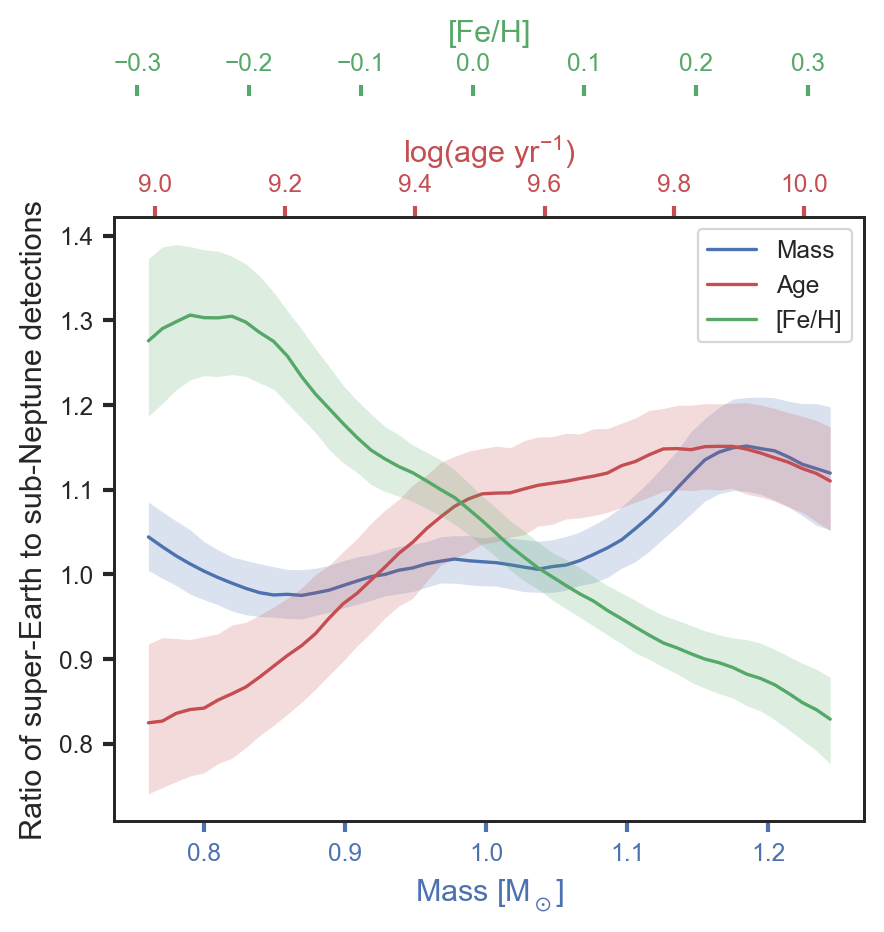

In [29]:
def trend_mc_sim(cks, m, var, nsamples=1000, bin_strat='scott'):
    
    if var=='mass':    
        _med, _err_lo, _err_hi = cks['f18_Miso'], cks['f18_e_Miso'], cks['f18_E_Miso']
                      
    elif var=='feh':
        _med, _err_lo, _err_hi = cks['f18_[Fe/H]'], cks['f18_e_[Fe/H]'], cks['f18_E_[Fe/H]']
        
    elif var=='age': 
        _med, _err_lo, _err_hi = cks['f18_logAiso'], cks['f18_e_logAiso'], cks['f18_E_logAiso']
    
    if bin_strat=='scott':
        _binwidth = 3.0*3.49*np.std(_med[m])/(len(_med[m])**(1./3.))
        
    elif bin_strat=='fd':
        _binwidth = 2.0*stats.iqr(_med[m])/(len(_med[m])**(1./3.))
         
    bin_centers = np.linspace(np.percentile(_med[m], 5.), np.percentile(_med[m], 95), 50)                  
    
    ratio = np.zeros([len(bin_centers), nsamples])

    mc_var = np.array([np.random.normal(_med, 
                                         np.max([_err_lo, _err_hi], axis=0)) for n in range(nsamples)])
    m_duplic = np.repeat([m], nsamples, axis=0)
    
    p_duplic = np.repeat([cks['f18_P']], nsamples, axis=0)
    
    Rp_duplic = np.repeat([cks['f18_Rp']], nsamples, axis=0)
    ERp_dupl =  np.repeat([cks['f18_E_Rp']], nsamples, axis=0)
    eRp_dupl =  np.repeat([cks['f18_e_Rp']], nsamples, axis=0)
    
    mc_rp = np.random.normal(Rp_duplic, 
                                 np.max([ERp_dupl,eRp_dupl], axis=0)) - Rp_valley(p_duplic, ref='RO20')
    
    for i in range(len(bin_centers)):          
        mask = m_duplic & (mc_var>=bin_centers[i]-_binwidth) & (mc_var<bin_centers[i]+_binwidth)
   
        for j in range(nsamples):
            mc_rp_ = mc_rp[j][mask[j]]
            
            try:
                ratio[i,j] = len(mc_rp_[mc_rp_<0])/len(mc_rp_[mc_rp_>=0])
            except ZeroDivisionError:
                ratio[i,j] = np.nan
                
    return bin_centers, ratio 



def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


def trend_plot(fig_path=None):

    colors = ['r','g','b']
    variables = ['mass', 'age', 'feh']

    fig, host = plt.subplots()
    fig.subplots_adjust(right=0.75)

    par1 = host.twiny()
    par2 = host.twiny()

    par2.spines["top"].set_position(("axes", 1.2))
    make_patch_spines_invisible(par2)
    par2.spines["right"].set_visible(True)

    mass_bin_centers, mass_ratio = trend_mc_sim(cks, m=base_sample, var='mass')
    feh_bin_centers, feh_ratio = trend_mc_sim(cks, m=base_sample, var='feh')
    age_bin_centers, age_ratio = trend_mc_sim(cks, m=base_sample, var='age')

    p1, = host.plot(mass_bin_centers, np.nanmedian(mass_ratio, axis=1), "b-", label="Mass")
    p2, = par1.plot(age_bin_centers, np.nanmedian(age_ratio, axis=1), "r-", label="Age")
    p3, = par2.plot(feh_bin_centers, np.nanmedian(feh_ratio, axis=1), "g-", label="[Fe/H]")

    ci = 68.3

    host.fill_between(mass_bin_centers, 
                            np.nanpercentile(mass_ratio, 50.-0.5*ci, axis=1), 
                            np.nanpercentile(mass_ratio, 50.+0.5*ci, axis=1), 
                            alpha=0.2, color='b', lw=0, zorder=999)

    par1.fill_between(age_bin_centers, 
                            np.nanpercentile(age_ratio, 50.-0.5*ci, axis=1), 
                            np.nanpercentile(age_ratio, 50.+0.5*ci, axis=1), 
                            alpha=0.2, color='r', lw=0, zorder=999)

    par2.fill_between(feh_bin_centers, 
                            np.nanpercentile(feh_ratio, 50.-0.5*ci, axis=1), 
                            np.nanpercentile(feh_ratio, 50.+0.5*ci, axis=1), 
                            alpha=0.2, color='g', lw=0, zorder=999)

    host.set_ylabel('Ratio of super-Earth to sub-Neptune detections', size=11)
    host.set_xlabel(r"Mass [$\mathregular{M_\odot}$]", size=11)
    par1.set_xlabel(r"log(age yr$^\mathregular{-1}$)", size=11)
    par2.set_xlabel("[Fe/H]", size=11)

    host.xaxis.label.set_color(p1.get_color())
    par1.xaxis.label.set_color(p2.get_color())
    par2.xaxis.label.set_color(p3.get_color())

    tkw = dict(size=4, width=1.5)
    host.tick_params(axis='x', colors=p1.get_color(), **tkw)
    par1.tick_params(axis='x', colors=p2.get_color(), **tkw)
    par2.tick_params(axis='x', colors=p3.get_color(), **tkw)
    host.tick_params(axis='y', **tkw)

    lines = [p1, p2, p3]

    host.legend(lines, [l.get_label() for l in lines])
    
    if fig_path:
        plt.savefig(fig_path)
    plt.show()
    
    return

trend_plot('../figures/trends.pdf')

### Differences in young and old planet size distributions for the restricted sample (Fig. 5)

In [24]:
from scipy import stats

112 planets in the young sample
90 planets in the old sample
202 planets in the restricted sample
117 unique hosts in the restricted sample


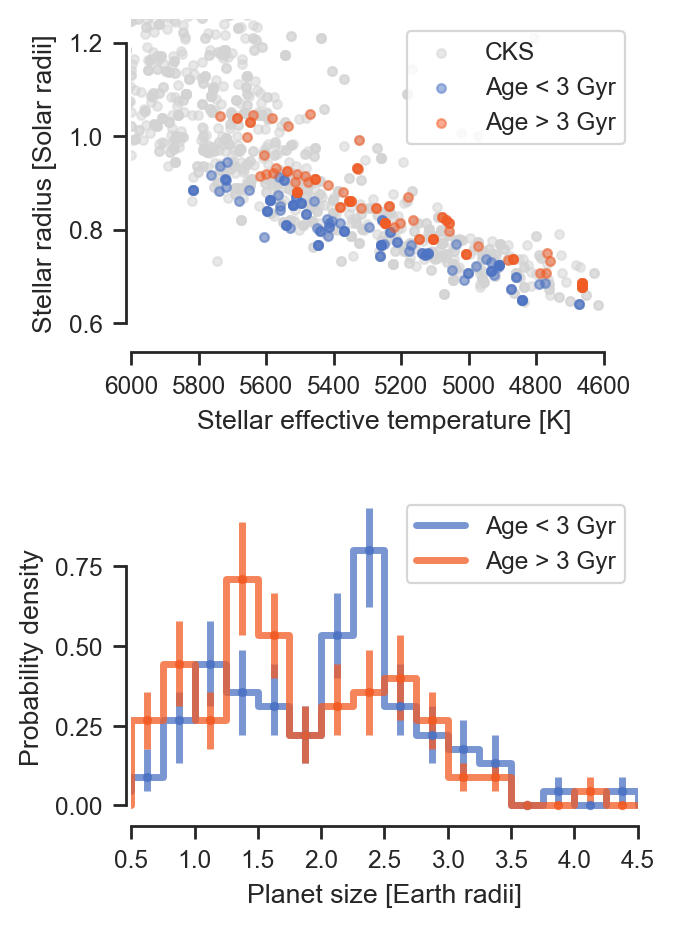

SE/SN ratio (<3 Gyr):
0.657 +/- 0.143
SE/SN ratio (>3 Gyr):
1.278 +/- 0.276
Significance (sigma): 2.2527543498025815
A-D result: Anderson_ksampResult(statistic=1.4683581756411968, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.08054239972396529)


In [43]:
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

def unbiased(restricted_sample, 
             fig_path=None):

    np.random.seed(2020)

    scatter_kwargs = {'alpha': 0.5, 's': 10}

    yng = restricted_sample & (cks['f18_logAiso']<np.log10(3e9))
    old = restricted_sample & (cks['f18_logAiso']>np.log10(3e9))

    plt.subplot(211)
    plt.scatter(cks['f18_Teff'], cks['f18_R'], label='CKS',  color='lightgrey', **scatter_kwargs)
    plt.scatter(cks['f18_Teff'][yng], cks['f18_R'][yng], label='Age < 3 Gyr', color=yng_color, **scatter_kwargs)
    plt.scatter(cks['f18_Teff'][old], cks['f18_R'][old], label='Age > 3 Gyr', color=old_color, **scatter_kwargs)

    plt.xlim(6000,4500)
    plt.ylim(0.55,1.25)

    plt.ylabel('Stellar radius [Solar radii]')
    plt.xlabel('Stellar effective temperature [K]')
    plt.legend()
    
    plt.subplot(212)

    x1 = cks['f18_Rp'][yng]
    x1err = cks['f18_E_Rp'][yng]
    x2 = cks['f18_Rp'][old]
    x2err = cks['f18_E_Rp'][old]

    print(len(cks[yng]), 'planets in the young sample')
    print(len(cks[old]), 'planets in the old sample')
    print(len(cks[restricted_sample]),'planets in the restricted sample') 
    print(len(np.unique(cks['f18_KOI_star'][restricted_sample])),'unique hosts in the restricted sample') 

    ad_result = stats.anderson_ksamp([x1, x2])
    
    rpbins = np.arange(0,5,0.25)

    nboot = 5000
    hist1 = []
    hist2 = []

    rp_yng = []
    rp_old = []
    
    np.random.seed(2020)

    for i in range(nboot):

        arg1 = np.random.choice(len(x1), np.min([len(x1),len(x2)]), replace=True)
        arg2 = np.random.choice(len(x2), np.min([len(x1),len(x2)]), replace=True)

        x1sim = np.array(x1)
        x2sim = np.array(x2)

        _hist1, bin_edges = np.histogram(x1sim[arg1], bins=rpbins, density=True)
        _hist2, bin_edges = np.histogram(x2sim[arg2], bins=rpbins, density=True)

        hist1.append(_hist1)
        hist2.append(_hist2)

        rp_yng.append(x1sim[arg1])
        rp_old.append(x2sim[arg2])


    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    hist1_e = np.median(hist1, axis=0)-np.percentile(hist1, 16., axis=0)
    hist1_E = np.percentile(hist1, 84., axis=0)-np.median(hist1, axis=0)

    hist2_e = np.median(hist2, axis=0)-np.percentile(hist2, 16., axis=0)
    hist2_E = np.percentile(hist2, 84., axis=0)-np.median(hist2, axis=0)

    hist_kwargs = {'alpha':0.75, 'lw':2.5}

    plt.plot(bin_centers, np.median(hist1, axis=0), drawstyle='steps-mid', color=yng_color, label=r'Age < 3 Gyr', **hist_kwargs)
    plt.errorbar(bin_centers, np.median(hist1, axis=0), yerr=[hist1_e, hist1_E], fmt='.', color=yng_color, **hist_kwargs)
    plt.plot(bin_centers, np.median(hist2, axis=0), drawstyle='steps-mid', color=old_color, label=r'Age > 3 Gyr', **hist_kwargs)
    plt.errorbar(bin_centers, np.median(hist2, axis=0), yerr=[hist2_e, hist2_E], fmt='.', color=old_color, **hist_kwargs)
    plt.xlabel('Planet size [Earth radii]')
    plt.ylabel('Probability density')
    plt.legend()
    plt.xticks(np.arange(0.5,5,0.5))
    plt.xlim(0.5,4.5)

    sns.despine(offset=2, trim=True)

    plt.tight_layout()
    plt.gcf().set_size_inches(3,5)
    if fig_path:
        plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    
    
    rp_yng = np.array(rp_yng)
    rp_old = np.array(rp_old)

    ratio_yng = []
    for i in range(nboot):
        _rp = rp_yng[i][:]
        ratio_yng.append(len(_rp[_rp<1.8])/len(_rp[_rp>1.8]))

    ratio_old = []    
    for i in range(nboot):    
        _rp = rp_old[i][:]
        ratio_old.append(len(_rp[_rp<1.8])/len(_rp[_rp>1.8]))    

        
    def round_results(x):
        print(np.round(np.mean(x),3),"+/-",np.round(np.std(x),3))
        return

    print('SE/SN ratio (<3 Gyr):')
    round_results(ratio_yng)
    print('SE/SN ratio (>3 Gyr):')
    round_results(ratio_old)
    
    print('Significance (sigma):', (np.mean(ratio_old)-np.mean(ratio_yng))/np.max([np.std(ratio_yng),np.std(ratio_old)]))
    print('A-D result:', ad_result)
    return
    

unbiased(restricted_sample, 
         fig_path='../figures/unbiased.pdf')

### Visualizing samples in the H-R diagram

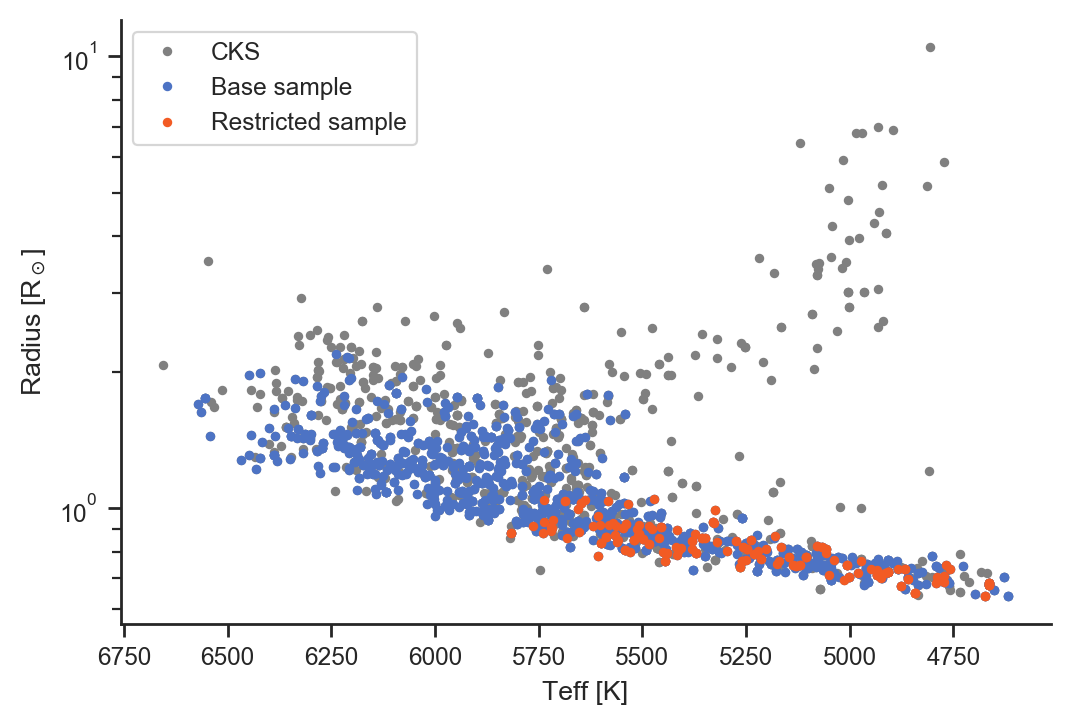

In [31]:
plt.plot(cks['f18_Teff'], cks['f18_R'],'.', color='grey', label="CKS")
plt.plot(cks['f18_Teff'][base_sample], cks['f18_R'][base_sample],'.', color=yng_color, label="Base sample")
plt.plot(cks['f18_Teff'][restricted_sample], cks['f18_R'][restricted_sample],'.', color=old_color, label="Restricted sample")
plt.gca().invert_xaxis()
plt.xlabel("Teff [K]")
plt.ylabel("Radius [R$_\odot$]")
plt.legend()
plt.semilogy()
plt.show()

### Visualizing asymmetric age uncertainties

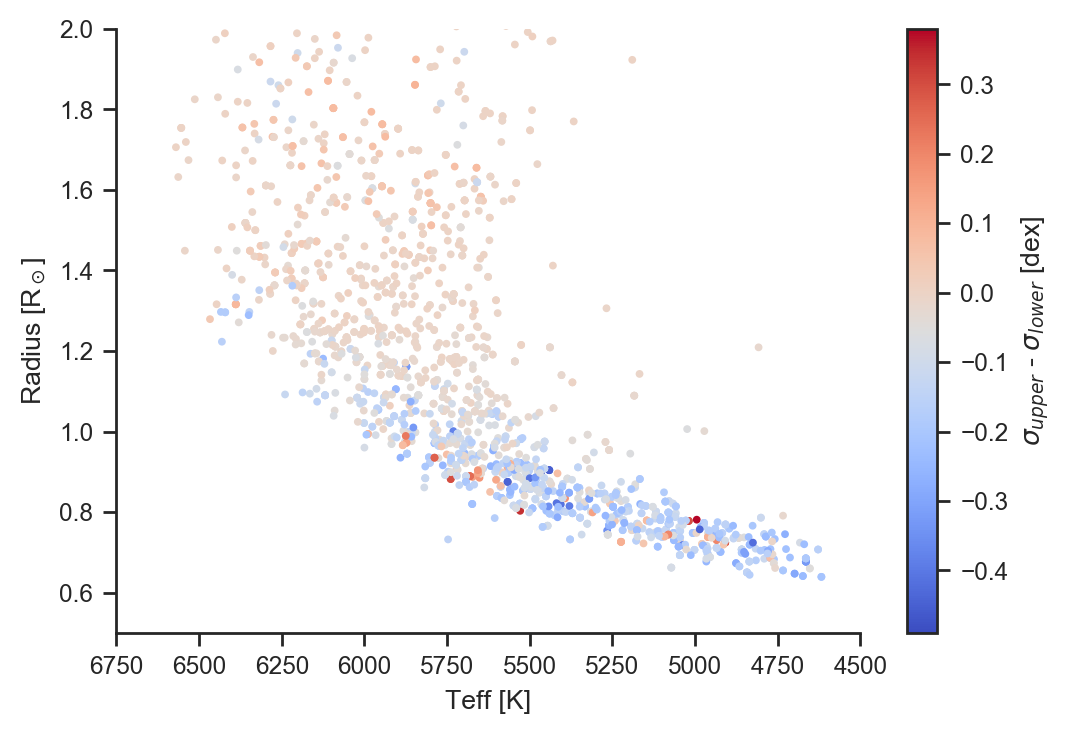

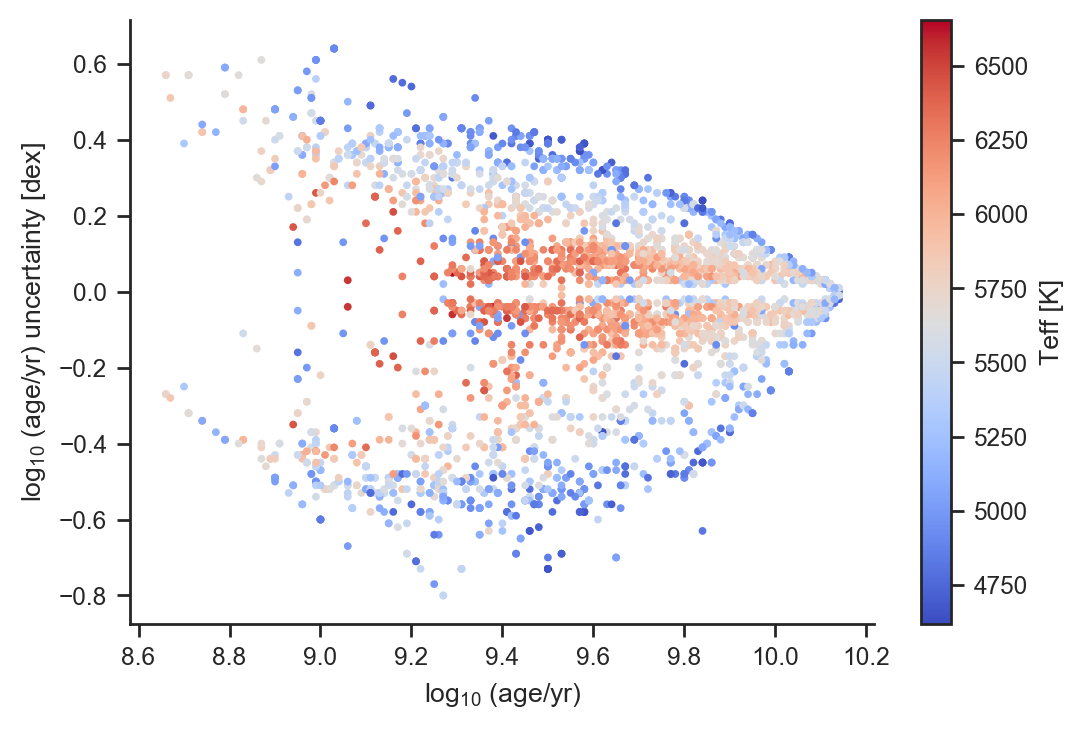

In [32]:
plt.scatter(cks['f18_Teff'], cks['f18_R'], c=cks['f18_E_logAiso']-cks['f18_e_logAiso'], s=4, cmap='coolwarm')
plt.ylim(0.5,2)
plt.xlim(6750,4500)
plt.colorbar(label=r'$\sigma_{upper}$ - $\sigma_{lower}$ [dex]')
plt.xlabel('Teff [K]')
plt.ylabel(r'Radius [R$_\odot$]')
plt.show()

plt.scatter(cks['f18_logAiso'], cks['f18_E_logAiso'], c=cks['f18_Teff'], s=4, cmap='coolwarm')
plt.scatter(cks['f18_logAiso'], -cks['f18_e_logAiso'], c=cks['f18_Teff'], s=4, cmap='coolwarm')

plt.colorbar(label='Teff [K]')
plt.xlabel(r'log$_\mathregular{10}$ (age/yr)')
plt.ylabel(r'log$_\mathregular{10}$ (age/yr) uncertainty [dex]')
plt.show()